## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
import scipy
from scipy import special
from scipy.special import boxcox1p
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# import data

athletes_df = pd.read_csv('athlete_events.csv')
noc_df = pd.read_csv('noc_regions.csv')
latitude_df = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')

## Data Cleaning

In [3]:
# rename "region" to "country"

noc_df.rename(columns = {'region':'country'}, inplace = True)

In [4]:
# drop unnecessary columns for longitude, US information and country code
latitude_df.drop(columns = [
    'longitude',
    'country_code', 
    'usa_state_code',
    'usa_state_latitude',
    'usa_state_longitude',
    'usa_state'], inplace = True)

In [5]:
# use country as index

latitude_df.set_index('country', inplace = True)

In [6]:
# create dictionary for country:latitude

latitude_dict = latitude_df.to_dict()['latitude']

In [7]:
# use NOC as index

noc_df.set_index('NOC', inplace = True)

In [8]:
# create dictionary for NOC:country

country_dict = noc_df.to_dict()['country']

In [9]:
# use NOC column in athletes_df to look up country name in country dictionary

athletes_df['country'] = athletes_df['NOC'].map(country_dict)

In [10]:
# use country column in athletes_df to look up latitude in latitude dictionary

athletes_df['latitude'] = athletes_df['country'].map(latitude_dict)

In [11]:
# check for null values in country

athletes_df[athletes_df['country'].isnull()];

In [12]:
# determine why Singapore is coming up as a null value

noc_df_singapore = noc_df[noc_df['country'] == 'Singapore']

In [13]:
# From noc_df, NOC is SIN, but from athletes_df, NOC is SGP. Therefore, update athletes_df from SGP to SIN.

athletes_df['NOC'].replace({'SGP' : 'SIN'}, inplace = True)

In [14]:
# check for null values in latitude

country_nan = athletes_df[athletes_df['latitude'].isnull()]

In [15]:
# find unique country names

country_nan['country'].drop_duplicates();

In [16]:
# rename countries from the latitude_dict

athletes_df['country'].replace({'USA' : 'United States', 
                                'UK' : 'United Kingdom', 
                                'Trinidad' : 'Trinidad and Tobago',
                                'Virgin Islands, US' : 'U.S. Virgin Islands',
                                'Macedonia' : 'Macedonia [FYROM]', 
                                'Ivory Coast' : "Côte d'Ivoire", 
                                'Curacao' : 'Netherlands Antilles'}, inplace = True)

# only Individual Olympic Athletes should be left with null values

In [17]:
# use country column in athletes_df to look up latitude in latitude dictionary

athletes_df['latitude'] = athletes_df['country'].map(latitude_dict)

In [18]:
noc_ioa = athletes_df[athletes_df['latitude'].isnull()]

In [19]:
# drop the results for IOA as there is no country associated. 

olympic_df = athletes_df[athletes_df['latitude'].notna()]

In [20]:
olympic_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,country,latitude
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,35.861660
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,35.861660
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,56.263920
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,56.263920
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,52.132633


## Finding Number of Teams Sent

Count teams as one, but count all instances of athlete competing in different events (for example, Michael Phelps)

In [21]:
#get number of medals awarded by event by year

medals_by_event_and_year = olympic_df.groupby(['Event','Year'])["Medal"].count().reset_index()
medals_by_event_and_year

,Event,Year,Medal
0,Aeronautics Mixed Aeronautics,1936,1
1,Alpine Skiing Men's Combined,1936,3
2,Alpine Skiing Men's Combined,1948,3
3,Alpine Skiing Men's Combined,1988,3
4,Alpine Skiing Men's Combined,1992,3
...,...,...,...
6187,"Wrestling Women's Lightweight, Freestyle",2016,4
6188,"Wrestling Women's Middleweight, Freestyle",2004,3
6189,"Wrestling Women's Middleweight, Freestyle",2008,4
6190,"Wrestling Women's Middleweight, Freestyle",2012,4


In [22]:
#remove the events with zero medals awarded

zero_med_events = medals_by_event_and_year[medals_by_event_and_year["Medal"]==0]
zero_med_events["EvYear"] = zero_med_events["Event"] + zero_med_events["Year"].astype(str)
olympic_df["EvYear"] = olympic_df["Event"] + olympic_df["Year"].astype(str)
olympic_df = olympic_df[~olympic_df.EvYear.isin(zero_med_events.EvYear)]

In [23]:
#average number of medals per event

#assuming ties are few and far between for a randomly chosen event that has occurrences in multiple olympics
avg_medals_by_event = medals_by_event_and_year.groupby(['Event'])["Medal"].mean().reset_index()

#do integer division by 3 to round down
avg_medals_by_event["Team Size"] = avg_medals_by_event["Medal"] // 3

#get medals where team size is less than 1
avg_medals_by_event[avg_medals_by_event["Team Size"] < 1]

,Event,Medal,Team Size
0,Aeronautics Mixed Aeronautics,1.000000,0.0
16,Archery Men's Championnat Du Monde,2.000000,0.0
27,"Archery Men's Target Archery, 28 metres, Indiv...",2.000000,0.0
29,"Archery Men's Target Archery, 33 metres, Indiv...",2.000000,0.0
31,"Archery Men's Target Archery, 50 metres, Indiv...",2.000000,0.0
35,Archery Men's Unknown Event,0.000000,0.0
41,Art Competitions Mixed Architecture,2.000000,0.0
44,"Art Competitions Mixed Architecture, Unknown E...",0.000000,0.0
45,Art Competitions Mixed Literature,2.750000,0.0
46,"Art Competitions Mixed Literature, Dramatic Works",0.500000,0.0


In [24]:
#all the medals with average number of medals below 3, change team size to 1 (assuming all these events were individual)

avg_medals_by_event.replace(0,1, inplace=True)
avg_medals_by_event.sort_values('Team Size', ascending=False)

,Event,Medal,Team Size
381,"Gymnastics Men's Team All-Around, Swedish System",73.500000,24.0
158,Baseball Men's Baseball,67.200000,22.0
395,Ice Hockey Women's Ice Hockey,60.000000,20.0
380,"Gymnastics Men's Team All-Around, Free System",54.500000,18.0
435,Rowing Men's 17-Man Naval Rowing Boats,51.000000,17.0
...,...,...,...
276,Cycling Men's Points Race,3.000000,1.0
277,"Cycling Men's Road Race, Individual",2.961538,1.0
279,Cycling Men's Sprint,3.000000,1.0
284,Cycling Women's 500 metres Time Trial,3.000000,1.0


In [25]:
#count names since count excludes NaNs (not feasible to count medal)

count_all_participants = olympic_df.groupby(['country','latitude','Event','Year','Season'])["Name"].count().reset_index()
count_all_participants

,country,latitude,Event,Year,Season,Name
0,Afghanistan,33.939110,Athletics Men's 100 metres,1936,Summer,1
1,Afghanistan,33.939110,Athletics Men's 100 metres,1960,Summer,1
2,Afghanistan,33.939110,Athletics Men's 100 metres,1996,Summer,1
3,Afghanistan,33.939110,Athletics Men's 100 metres,2004,Summer,1
4,Afghanistan,33.939110,Athletics Men's 100 metres,2008,Summer,1
...,...,...,...,...,...,...
112360,Zimbabwe,-19.015438,Tennis Women's Singles,2008,Summer,1
112361,Zimbabwe,-19.015438,Triathlon Men's Olympic Distance,2000,Summer,1
112362,Zimbabwe,-19.015438,Triathlon Men's Olympic Distance,2008,Summer,1
112363,Zimbabwe,-19.015438,Triathlon Men's Olympic Distance,2012,Summer,1


In [26]:
#count medals to exclude NaN

count_all_medalists = olympic_df.groupby(['country','Event','Year','Season'])["Medal"].count().reset_index().rename(columns={"Medal":"Medalists"})

In [27]:
country_teams_sent=count_all_participants.merge(avg_medals_by_event,how='left',left_on='Event',right_on='Event')
country_teams_sent["Num Teams Sent"] = country_teams_sent["Name"] // country_teams_sent["Team Size"]
country_teams_sent[country_teams_sent["Num Teams Sent"] < 1]

,country,latitude,Event,Year,Season,Name,Medal,Team Size,Num Teams Sent
24,Afghanistan,33.939110,Football Men's Football,1948,Summer,11,47.000000,15.0,0.0
25,Afghanistan,33.939110,Hockey Men's Hockey,1936,Summer,13,45.652174,15.0,0.0
26,Afghanistan,33.939110,Hockey Men's Hockey,1948,Summer,14,45.652174,15.0,0.0
27,Afghanistan,33.939110,Hockey Men's Hockey,1956,Summer,12,45.652174,15.0,0.0
328,Algeria,28.033886,"Fencing Men's Sabre, Team",2004,Summer,3,15.360000,5.0,0.0
...,...,...,...,...,...,...,...,...,...
111665,Venezuela,6.423750,Swimming Women's 4 x 100 metres Freestyle Relay,1976,Summer,4,15.083333,5.0,0.0
111666,Venezuela,6.423750,Swimming Women's 4 x 100 metres Medley Relay,1976,Summer,4,18.133333,6.0,0.0
111905,Vietnam,14.058324,Swimming Men's 4 x 100 metres Medley Relay,1980,Summer,4,18.600000,6.0,0.0
112110,Zambia,-13.133897,Football Men's Football,1980,Summer,14,47.000000,15.0,0.0


In [28]:
#as before, replace the zero teams sent to one

country_teams_sent.replace(0,1, inplace=True)
country_teams_totals = country_teams_sent.groupby(['country','latitude','Season'])["Num Teams Sent"].sum().reset_index().sort_values("Num Teams Sent",ascending=False)
country_teams_totals

,country,latitude,Season,Num Teams Sent
287,United States,37.090240,Summer,10041.0
98,Germany,51.165691,Summer,8169.0
285,United Kingdom,55.378051,Summer,7489.0
92,France,46.227638,Summer,7323.0
224,Russia,61.524010,Summer,5987.0
...,...,...,...,...
76,Dominica,15.414999,Winter,1.0
268,Timor-Leste,-8.874217,Winter,1.0
210,Paraguay,-23.442503,Winter,1.0
272,Tonga,-21.178986,Winter,1.0


In [29]:
#merge countries and medalists into one dataframe

country_medalists_sent = count_all_medalists.merge(avg_medals_by_event,how='left',left_on='Event',right_on='Event')
country_medalists_sent["Num Medalists Sent"] = country_medalists_sent["Medalists"] // country_medalists_sent["Team Size"]
country_medalists_totals = country_medalists_sent.groupby(['country','Season'])["Num Medalists Sent"].sum().reset_index().sort_values("Num Medalists Sent",ascending=False)
country_medalists_totals

,country,Season,Num Medalists Sent
287,United States,Summer,2524.0
224,Russia,Summer,1547.0
98,Germany,Summer,1356.0
285,United Kingdom,Summer,867.0
92,France,Summer,748.0
...,...,...,...
1,Albania,Summer,0.0
151,Liberia,Summer,0.0
152,Libya,Summer,0.0
153,Liechtenstein,Summer,0.0


In [30]:
#merge country and medalists into one dataframe

country_merged = country_teams_totals.merge(country_medalists_totals,how='left',left_on=['country','Season'],right_on=['country','Season'])
country_merged["Success Rate"] = country_merged["Num Medalists Sent"]/country_merged["Num Teams Sent"]
country_merged

,country,latitude,Season,Num Teams Sent,Num Medalists Sent,Success Rate
0,United States,37.090240,Summer,10041.0,2524.0,0.251369
1,Germany,51.165691,Summer,8169.0,1356.0,0.165993
2,United Kingdom,55.378051,Summer,7489.0,867.0,0.115770
3,France,46.227638,Summer,7323.0,748.0,0.102144
4,Russia,61.524010,Summer,5987.0,1547.0,0.258393
...,...,...,...,...,...,...
296,Dominica,15.414999,Winter,1.0,0.0,0.000000
297,Timor-Leste,-8.874217,Winter,1.0,0.0,0.000000
298,Paraguay,-23.442503,Winter,1.0,0.0,0.000000
299,Tonga,-21.178986,Winter,1.0,0.0,0.000000


In [31]:
#define condition for winter or summer country

def WinSum(row):
    if row['latitude'] >= 35 or row['latitude'] <= -35:
        val = 'Winter'
    else:
        val = 'Summer'
    return val

In [32]:
country_merged["Specialty"] = country_merged.apply(WinSum,axis=1)
country_merged

,country,latitude,Season,Num Teams Sent,Num Medalists Sent,Success Rate,Specialty
0,United States,37.090240,Summer,10041.0,2524.0,0.251369,Winter
1,Germany,51.165691,Summer,8169.0,1356.0,0.165993,Winter
2,United Kingdom,55.378051,Summer,7489.0,867.0,0.115770,Winter
3,France,46.227638,Summer,7323.0,748.0,0.102144,Winter
4,Russia,61.524010,Summer,5987.0,1547.0,0.258393,Winter
...,...,...,...,...,...,...,...
296,Dominica,15.414999,Winter,1.0,0.0,0.000000,Summer
297,Timor-Leste,-8.874217,Winter,1.0,0.0,0.000000,Summer
298,Paraguay,-23.442503,Winter,1.0,0.0,0.000000,Summer
299,Tonga,-21.178986,Winter,1.0,0.0,0.000000,Summer


Slightly differs from real counts. Some reasons would include:
- Some events didn't award silver or bronze medals due to lack of participants (mainly early 1900's)
- Data set doesn't count 2018 olympics
- The way events/teams are classified in this data set in the early 1900's is difficult to filter through

## Hypothesis Testing

In [33]:
# conduct two-sample t-test where H-null is equal means for both populations

#specialty country, season olympics: 4 possible combos

summer_c_summer_o = country_merged[(country_merged['Specialty'] == 'Summer') & (country_merged['Season'] == 'Summer')]['Success Rate']
winter_c_summer_o = country_merged[(country_merged['Specialty'] == 'Winter') & (country_merged['Season'] == 'Summer')]['Success Rate']
summer_c_winter_o = country_merged[(country_merged['Specialty'] == 'Summer') & (country_merged['Season'] == 'Winter')]['Success Rate']
winter_c_winter_o = country_merged[(country_merged['Specialty'] == 'Winter') & (country_merged['Season'] == 'Winter')]['Success Rate']

stats.ttest_ind(summer_c_summer_o, winter_c_summer_o)

Ttest_indResult(statistic=-8.61175581777362, pvalue=2.6620080242169857e-15)

In [34]:
stats.ttest_ind(summer_c_winter_o, winter_c_winter_o)

Ttest_indResult(statistic=-4.2440715746676005, pvalue=4.717396260153184e-05)

With a very low p-value, we reject both $H_0$ and declare that the means between winter and summer populations in the separate olympics are not equal.

In [35]:
# pivoting table to show participants and medals won per country in both summer and winter olympics

pivot = pd.pivot_table(country_merged, values = ['Num Teams Sent', 'Num Medalists Sent'], index=['country','Specialty'], columns=['Season'], aggfunc=sum)
pivot

Num Medalists Sent        Num Teams Sent       
Season                               Summer Winter         Summer Winter
country        Specialty                                                
Afghanistan    Summer                   2.0    NaN           77.0    NaN
Albania        Winter                   0.0    0.0           63.0    7.0
Algeria        Summer                  17.0    0.0          414.0   12.0
American Samoa Summer                   0.0    0.0           34.0    1.0
Andorra        Winter                   0.0    0.0           51.0  116.0
...                                     ...    ...            ...    ...
Venezuela      Summer                  15.0    0.0          720.0    7.0
Vietnam        Summer                   4.0    NaN          201.0    NaN
Yemen          Summer                   0.0    NaN           48.0    NaN
Zambia         Summer                   2.0    NaN          147.0    NaN
Zimbabwe       Summer                   8.0    0.0          257.0    2.0

[193 rows x 4 columns]

In [36]:
# drop rows with NA values to limit dataset to countries who participated in both winter and summer olympics for better comparison

pivot.dropna(inplace=True)
pivot

Num Medalists Sent        Num Teams Sent        
Season                               Summer Winter         Summer  Winter
country        Specialty                                                 
Albania        Winter                   0.0    0.0           63.0     7.0
Algeria        Summer                  17.0    0.0          414.0    12.0
American Samoa Summer                   0.0    0.0           34.0     1.0
Andorra        Winter                   0.0    0.0           51.0   116.0
Argentina      Winter                  74.0    0.0         1737.0   357.0
...                                     ...    ...            ...     ...
United States  Winter                2524.0  277.0        10041.0  2737.0
Uruguay        Summer                   9.0    0.0          341.0     1.0
Uzbekistan     Winter                  33.0    1.0          424.0    27.0
Venezuela      Summer                  15.0    0.0          720.0     7.0
Zimbabwe       Summer                   8.0    0.0          257.0     2.0

[108 rows x 4 columns]

In [37]:
# stack season back into an index for easier processing

tab = pivot.stack()
tab

Num Medalists Sent  Num Teams Sent
country        Specialty Season                                    
Albania        Winter    Summer                 0.0            63.0
                         Winter                 0.0             7.0
Algeria        Summer    Summer                17.0           414.0
                         Winter                 0.0            12.0
American Samoa Summer    Summer                 0.0            34.0
...                                             ...             ...
Uzbekistan     Winter    Winter                 1.0            27.0
Venezuela      Summer    Summer                15.0           720.0
                         Winter                 0.0             7.0
Zimbabwe       Summer    Summer                 8.0           257.0
                         Winter                 0.0             2.0

[216 rows x 2 columns]

In [38]:
# reset index for easier crosstab manipulation

tab.reset_index(inplace=True)
tab

,country,Specialty,Season,Num Medalists Sent,Num Teams Sent
0,Albania,Winter,Summer,0.0,63.0
1,Albania,Winter,Winter,0.0,7.0
2,Algeria,Summer,Summer,17.0,414.0
3,Algeria,Summer,Winter,0.0,12.0
4,American Samoa,Summer,Summer,0.0,34.0
...,...,...,...,...,...
211,Uzbekistan,Winter,Winter,1.0,27.0
212,Venezuela,Summer,Summer,15.0,720.0
213,Venezuela,Summer,Winter,0.0,7.0
214,Zimbabwe,Summer,Summer,8.0,257.0


In [39]:
# create a contingency table using medal counts for country season types, broken down by summer and winter olympics

obs = pd.crosstab(tab['Specialty'], tab['Season'], tab['Num Medalists Sent'], aggfunc=sum)
obs.astype(int)

Season,Summer,Winter
Specialty,,
Summer,1363,15
Winter,13993,2831


In [40]:
# do contingency test and check if the row and column sums of the expected values are equal to the row and column sums of the crosstab contingency table

chi2_contingency(obs)

(237.9844325832377,
 1.0819240137060211e-53,
 1,
 array([[ 1162.54081969,   215.45918031],
        [14193.45918031,  2630.54081969]]))

With expected value totals equal the contingency table sums, we can proceed with the chi-square test.

In [41]:
# do a chi-square test with null hypothesis indicating no relationship between a country's season and their performance on specific seasonal olympics

chisquare(obs, axis=None)

Power_divergenceResult(statistic=26996.682342599717, pvalue=0.0)

With a p-value of zero, we reject $H_0$ and conclude that there is a relationship between a country's season and their performance on specific seasonal olympics

## Transform non-normal data to apply Hypothesis testing

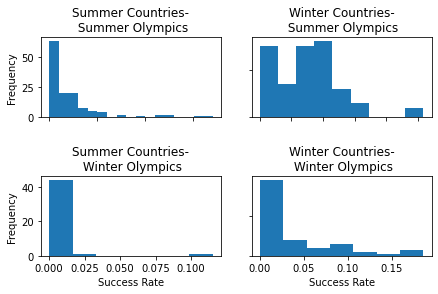

In [42]:
# Reference code: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(summer_c_summer_o, bins = 'auto')
axs[0, 0].set_title('Summer Countries-\n Summer Olympics')
axs[0, 1].hist(winter_c_summer_o, bins = 'auto')
axs[0, 1].set_title('Winter Countries-\n Summer Olympics')
axs[1, 0].hist(summer_c_winter_o, bins = 'auto')
axs[1, 0].set_title('Summer Countries-\n Winter Olympics')
axs[1, 1].hist(winter_c_winter_o, bins = 'auto')
axs[1, 1].set_title('Winter Countries-\n Winter Olympics')

fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='Success Rate', ylabel='Frequency')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [43]:
# reshape series to array to apply boxcox1p

summer_summer = np.array(summer_c_summer_o).reshape(-1,1)
winter_summer = np.array(winter_c_summer_o).reshape(-1,1)
summer_winter = np.array(summer_c_winter_o).reshape(-1,1)
winter_winter = np.array(winter_c_winter_o).reshape(-1,1)

In [44]:
# "how to calculate lambda", reference: https://stackoverflow.com/questions/63105754/how-do-i-calculate-lambda-to-use-scipy-special-boxcox1p-function-for-my-entire-d

pt = PowerTransformer(method='yeo-johnson')

pt.fit(summer_summer)
ss_lambda = pt.lambdas_
print(ss_lambda)

pt.fit(winter_summer)
ws_lambda = pt.lambdas_
print(ws_lambda)

pt.fit(winter_winter)
ww_lambda = pt.lambdas_
print(ww_lambda)

pt.fit(summer_winter)
sw_lambda = pt.lambdas_
print(sw_lambda)

[-32.13849158]
[-4.74593784]
[-20.92309404]
[-343.38344587]


In [45]:
# Use boxcox1p, reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.boxcox1p.html

summer_summer_trans = scipy.special.boxcox1p(summer_summer, ss_lambda)
winter_summer_trans = scipy.special.boxcox1p(winter_summer, ws_lambda)
winter_winter_trans = scipy.special.boxcox1p(winter_winter, ww_lambda)
summer_winter_trans = scipy.special.boxcox1p(summer_winter, sw_lambda)

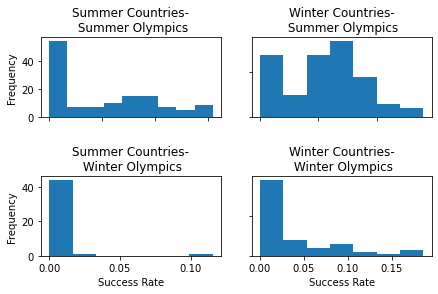

In [46]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(summer_summer_trans, bins = 'auto')
axs[0, 0].set_title('Summer Countries-\n Summer Olympics')
axs[0, 1].hist(winter_summer_trans, bins = 'auto')
axs[0, 1].set_title('Winter Countries-\n Summer Olympics')
axs[1, 0].hist(summer_winter, bins = 'auto')
axs[1, 0].set_title('Summer Countries-\n Winter Olympics')
axs[1, 1].hist(winter_winter, bins = 'auto')
axs[1, 1].set_title('Winter Countries-\n Winter Olympics')

fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='Success Rate', ylabel='Frequency')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [47]:
stats.ttest_ind(summer_summer_trans, winter_summer_trans)

Ttest_indResult(statistic=array([-13.95196052]), pvalue=array([5.80213656e-31]))

In [48]:
stats.ttest_ind(summer_winter_trans, winter_winter_trans)

Ttest_indResult(statistic=array([-6.4126232]), pvalue=array([4.06990226e-09]))

With a very low p-value, we reject both $H_0$ and declare that the means between winter and summer populations in the separate olympics are not equal.